In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from tensorflow.python import debug as tf_debug
from datetime import datetime 
%load_ext autotime
%matplotlib inline

In [2]:
flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_float('learning_rate', 0.0001, 'Initial learning rate.')
flags.DEFINE_integer('max_steps', 50000, 'Number of iteration to train.')
flags.DEFINE_integer('number_layers', 3, 'Number of layers in each network')
flags.DEFINE_integer('layer_sizes', 256, 'Number of units in hidden layer.')
flags.DEFINE_integer('batch_size', 500, 'Batch size.')
flags.DEFINE_integer('dim_env', 2, 'dimension of the environment')
flags.DEFINE_integer('number_goal_types', 3, 'number of different goal types')
flags.DEFINE_integer('color_size', 3, 'number of components of the color: RGB as usual')
flags.DEFINE_integer("output_size", 256, "number of units in the output layer")
flags.DEFINE_float("keep_prob", 0.9, "Dropouts rate of keeping")
flags.DEFINE_boolean("xav_init", False,"Distribution of initialization: False for normal, True for uniform" )
flags.DEFINE_integer("number_agents", 1, "Number of agents in the environment")
flags.DEFINE_integer("number_landmarks", 1, "Number of landmarks in the environment")
flags.DEFINE_integer("vocabulary_size", 20, "Size of the vocabulary")
flags.DEFINE_integer("mem_size", 32, "Size of the communication network's memory")
flags.DEFINE_integer("last_mem_size", 32, "Size of the last network's memory")
flags.DEFINE_float("gumbel_temperature", 1, "Temperature use for the gumbel softmax trick")
flags.DEFINE_float("sddev_phys_sampling", 0.0001, "Standard deviation used to sample the velocity and gaze output")
flags.DEFINE_float("delta_t", 0.1, "delta of time between timesteps")
flags.DEFINE_float("damping_coef", 0.5, "damping coefficient for the new velocity computation")
flags.DEFINE_float("stddev_memory", 0.0001, "standard deviation of the gaussian used to update memories")
flags.DEFINE_integer("bound", 5, "Bounds of generation of initial positions, centered in 0.")
flags.DEFINE_integer("time_horizon", 50, "Number of timestep before the end of the experiment.")
flags.DEFINE_integer("print_frequency", 500, "Frequency at which we print the reward, in number of steps.")
flags.DEFINE_boolean("learning_rate_decay", True, "Wether to use a piecewise learning rate decay or no decay at all")

time: 19 ms


In [14]:
tf.reset_default_graph()

time: 1 ms


### A faire:

- Checker que le softmax pooling est correct

- Checker que le gumbel trick est okay, notamment sur les début et longueur de slicing

- Checker que le sampling physique est okay, notamment sur les début et longueur de slicing

- Checker que le calcul du nouvel état est correct, notamment sur les débuts et longueur de slicing et concaténation

- Ajouter le calcul des forces dans le calcul du nouvel état

- Vérifier que le shuffling est correct

- Vérifier que le calcul du reward est correct

- Vérifier que la backprop considère bien les variables broadcastées comme les mêmes.

- Vérifier que le tenseur states est bien dans cet ordre sur le second axe: position, velocité, gaze, couleurs

- RELIER LES LANDMARKS AUX POSITIONS DES GOALS, SINON CA N A PAS DE SENS !!!

- Checker que les goals types sont bien distribués: une unique coordonnée doit être 1, les autres 0, et ce pour chaque agent.


## Utils

In [15]:
# Param: x, stacking of the output of fully connected physical network for each agent. Shape = (256, batch_size, nb_agents)
# return: pooling of input features.
def softmax_pooling(x):
    # pooling function. Softmax pooling is a compromise between max pooling and average pooling
    coefs = tf.nn.softmax(x, dim = 0)
    softmax_pool = tf.reduce_sum(tf.multiply(coefs, x), axis = 0)
    return softmax_pool


def activation_function(x):
    return tf.nn.elu(x)


def gumbel_max_trick(x):
    # Application of gumbel-softmax trick
    # Input: output of the last network 
    u = -tf.log(-tf.log(tf.random_uniform(shape = [FLAGS.number_agents, FLAGS.vocabulary_size, FLAGS.batch_size],
                                          dtype=tf.float32)))
    utterance_output = tf.slice(x, [0, 2*FLAGS.dim_env, 0], [FLAGS.number_agents, FLAGS.vocabulary_size, FLAGS.batch_size])
    gumbel = tf.exp((utterance_output + u)/FLAGS.gumbel_temperature)
    denoms = tf.reshape(tf.reduce_sum(gumbel, axis = 1), [FLAGS.number_agents, 1, FLAGS.batch_size])
    utterance = gumbel/denoms
    return utterance 


def sample_phys(x):
    #Input output of the last network.
    #Output: sampled values for new velocity and gaze
    u = tf.random_normal(shape = [FLAGS.number_agents, 2*FLAGS.dim_env, FLAGS.batch_size],dtype=tf.float32,
                         stddev = FLAGS.sddev_phys_sampling)
    o = tf.add(tf.slice(x, [0, 0, 0], [FLAGS.number_agents, 2*FLAGS.dim_env, FLAGS.batch_size]), u)
    sample_move = tf.slice(o, [0, 0, 0], [FLAGS.number_agents, FLAGS.dim_env, FLAGS.batch_size])
    sample_gaze  = tf.slice(o, [0, FLAGS.dim_env, 0], [FLAGS.number_agents, FLAGS.dim_env, FLAGS.batch_size])
    return sample_move, sample_gaze


def compute_new_states(old_states, new_velocities, new_gazes, new_utterances):
    #Computes the new states according to the equations of the papers.
    # Input: the old states of shape [number agents + nb_landmarks, 3*env dim + color size, batch size] because color is in state
    # and of shape [number_agents, 2*env_dim, batch size]
    # Adding the outputs of landmark, which are all zeros.
    new_velocities = tf.concat([new_velocities, tf.zeros([FLAGS.number_landmarks, FLAGS.dim_env, FLAGS.batch_size])],
                                           axis = 0)
    new_gazes = tf.concat([new_gazes, tf.zeros([FLAGS.number_landmarks, FLAGS.dim_env, FLAGS.batch_size])],
                                           axis = 0)
    
    old_velocity = tf.slice(old_states, [0, FLAGS.dim_env, 0], 
                            [FLAGS.number_agents + FLAGS.number_landmarks, FLAGS.dim_env, FLAGS.batch_size])
    new_pos = tf.slice(old_states, [0, 0, 0], 
                       [FLAGS.number_agents + FLAGS.number_landmarks, FLAGS.dim_env, FLAGS.batch_size]) + old_velocity
    
    new_velocity = (1 - FLAGS.damping_coef)*old_velocity + new_velocities*FLAGS.delta_t
    
    colors = tf.slice(old_states, [0, 3*FLAGS.dim_env, 0], [FLAGS.number_agents + FLAGS.number_landmarks, 
                                                            FLAGS.color_size, FLAGS.batch_size])
    new_states = tf.concat([new_pos, new_velocity, new_gazes, colors], axis = 1)

    return new_states, new_pos



def compute_new_memories(old_mem_com, old_mem_last, delta_mem_com, delta_mem_last):
    new_memory_com = tf.tanh(old_mem_com + delta_mem_com + tf.random_normal([FLAGS.number_agents, FLAGS.mem_size,
                                                                             FLAGS.batch_size], FLAGS.stddev_memory))
    new_memory_last = tf.tanh(old_mem_last + delta_mem_last + tf.random_normal([FLAGS.number_agents, FLAGS.mem_size,
                                                                             FLAGS.batch_size], FLAGS.stddev_memory))
    
    return new_memory_com,new_memory_last



def shuffle(x, name_targets, colors = False):
    slices_second_dim = []
    ones = tf.ones([FLAGS.number_agents, 1, FLAGS.batch_size], tf.int32)
    batch_num = tf.tile(tf.reshape(tf.range(0, FLAGS.batch_size, dtype = tf.int32), [1, 1, FLAGS.batch_size]), [FLAGS.number_agents,
                                                                                                               1, 1])
    if not colors:
        for i in range(FLAGS.dim_env):
            slices_second_dim.append(tf.reshape(tf.concat([name_targets, ones*i, batch_num], axis = 1), 
                                            [FLAGS.number_agents, 1, 3, FLAGS.batch_size]))
    else:
        for i in range(FLAGS.color_size):
            slices_second_dim.append(tf.reshape(tf.concat([name_targets, ones*i, batch_num], axis = 1), 
                                            [FLAGS.number_agents, 1, 3, FLAGS.batch_size]))
            
    gathering_tensor = tf.transpose(tf.concat(slices_second_dim, axis = 1), perm = [0, 1, 3, 2])
    shuffled_x = tf.gather_nd(x, gathering_tensor)
    
    return shuffled_x
    
    
def compute_reward(positions, gazes, outputs, utterances, name_targets, goals_loc, goals_types):
    shuffled_positions = shuffle(positions, name_targets)
    shuffled_gazes = shuffle(gazes, name_targets)
    
    pos_distances = tf.reshape(tf.reduce_sum(tf.square((shuffled_positions - goals_loc)), axis = 1), [FLAGS.number_agents, 1, 
                                                                                                     FLAGS.batch_size])
    gaze_distances = tf.reshape(tf.reduce_sum(tf.square((shuffled_gazes - goals_loc)), axis = 1), [FLAGS.number_agents, 1,
                                                                                                     FLAGS.batch_size])
    zeros = tf.zeros([FLAGS.number_agents, 1, FLAGS.batch_size])
    x = tf.concat([pos_distances, gaze_distances, zeros], axis = 1)
    dists_goal = -tf.reduce_sum(tf.multiply(x, goals_types), axis = 1)
    
    utterances_term = -tf.reduce_sum(tf.square(utterances), axis = 1)
    output_term = -tf.reduce_sum(tf.square(outputs), axis = 1)
    
    reward_by_batch = tf.reshape(tf.reduce_sum(dists_goal + utterances_term + 0.1 * output_term, axis = 0), [FLAGS.batch_size, 1])

    return reward_by_batch



def compute_goal_dist(states, goal_location, goal_type):
    dist_positions = np.reshape(np.sqrt(np.sum((states[0:FLAGS.number_agents, 0:2, :] - goal_location)**2, axis = 1)), [FLAGS.number_agents, 1, FLAGS.batch_size])
    dist_gazes = np.reshape(np.sqrt(np.sum((states[0:FLAGS.number_agents, 4:6, :] - goal_location)**2, axis = 1)), [FLAGS.number_agents, 1, FLAGS.batch_size])
    
    v = np.concatenate([dist_positions, dist_gazes, np.zeros((FLAGS.number_agents, 1, FLAGS.batch_size))], axis = 1)
    goal_distances = np.sum(np.multiply(v, goal_type), axis = 1)
    
    return goal_distances


def print_stats_agent(states, goal_location, goal_type):
    #Only considering non "do nothing goals"
    goal_distances = compute_goal_dist(states, goal_location, goal_type)
    
    for i in range(FLAGS.number_agents):
        distances_agents = goal_distances[i, :]
        goal_wo_zeros = distances_agents[distances_agents != 0]
        mean = np.mean(goal_wo_zeros)
        median = np.median(goal_wo_zeros)
        third_quart = np.percentile(goal_wo_zeros, 75)
        nine_pct = np.percentile(goal_wo_zeros, 90)
        max_dist = np.max(goal_wo_zeros)
        print("--- Agent " + str(i))
        print("------ Mean distance " + str(mean))
        print("------ Median distance " + str(median))
        print("------ Third quartile " + str(third_quart))
        print("------ Ninetieth percentile " + str(nine_pct))
        print("------ max distance " + str(max_dist))

time: 306 ms


## Definition of the physical network

In [16]:
class PhysicalNet: 
    
    def __init__(self):
        self.input_size = 3*FLAGS.dim_env + FLAGS.color_size
        
        self.Weights = []
        self.Biases = []
        
        self.init_weights()
        self.init_biases()
        
    def init_weights(self):
        #Initialization of the weights of all the networks' layers
        #Weights are 3 dimensional arrays: [number of agents, number of units, number of inputs]
        #This shape enables us to handle all the agents/landmarks states at once, instead of dealing with list of agents' states
        with tf.variable_scope("phys_variable") as scope:
            for i in range(FLAGS.number_layers):
                if i == 0:
                    W = tf.tile(tf.get_variable("weight_" + str(i), shape=[1, FLAGS.layer_sizes, self.input_size],
                                        initializer=tf.contrib.layers.xavier_initializer(FLAGS.xav_init)),
                                [FLAGS.number_agents + FLAGS.number_landmarks, 1, 1])
                    tf.summary.histogram('phys_net_weight_'+ str(i), W)
                elif i != (FLAGS.number_layers - 1):
                    W = tf.tile(tf.get_variable("weight_" + str(i), shape=[1, FLAGS.layer_sizes, FLAGS.layer_sizes],
                                        initializer=tf.contrib.layers.xavier_initializer(FLAGS.xav_init)),
                                [FLAGS.number_agents + FLAGS.number_landmarks, 1, 1])
                    tf.summary.histogram('phys_net_weight_'+ str(i), W)
                else:
                    W = tf.tile(tf.get_variable("weight_" + str(i), shape=[1, FLAGS.output_size, FLAGS.layer_sizes],
                                        initializer=tf.contrib.layers.xavier_initializer(FLAGS.xav_init)), 
                                [FLAGS.number_agents + FLAGS.number_landmarks, 1, 1])
                    tf.summary.histogram('phys_net_weight_'+ str(i), W)

                self.Weights.append(W)
            
    def init_biases(self):
        #Initialization of the weights of all the networks' biases.
        # Same remark as the weights concerning the shapes of the biases.
        with tf.variable_scope("phys_variable") as scope:
            for i in range(FLAGS.number_layers):
                if i < (FLAGS.number_layers - 1):
                    B = tf.tile(tf.get_variable("bias_" + str(i), shape=[1, FLAGS.layer_sizes, 1],
                                            initializer=tf.contrib.layers.xavier_initializer(FLAGS.xav_init)),
                                [FLAGS.number_agents + FLAGS.number_landmarks, 1, 1])
                    tf.summary.histogram('phys_net_bias_'+ str(i), B)
                else:
                    B = tf.tile(tf.get_variable("bias_" + str(i), shape=[1, FLAGS.output_size, 1],
                                            initializer=tf.contrib.layers.xavier_initializer(FLAGS.xav_init)),
                                [FLAGS.number_agents + FLAGS.number_landmarks, 1, 1])
                    
                self.Biases.append(B)
            
            
    def compute_output(self, x): 
        # Compute a forward pass through the network
        # Input: a tensor of shape [number of agents, size of input, batch _size]
        # Output: a tensor of shape [number of agents, output_size, batch_size]
            for i in range(FLAGS.number_layers):
                W = self.Weights[i]
                b = self.Biases[i]
                if i != (FLAGS.number_layers - 1):
                    x = tf.nn.dropout(activation_function(tf.matmul(W, x) + b), keep_prob = FLAGS.keep_prob)
                else:
                    x = activation_function(tf.matmul(W, x) + b)
            
            return x

time: 287 ms


## Definition of the communication network

In [17]:
class CommunicationNet: 
    
    def __init__(self):    
        self.Weights = []
        self.Biases = []
        self.Weight_read_mem = tf.tile(tf.get_variable("com_memory_read_weight", shape = [1, FLAGS.output_size, FLAGS.mem_size],
                                               initializer=tf.contrib.layers.xavier_initializer(FLAGS.xav_init)),
                                               [FLAGS.number_agents, 1, 1])
        
        self.init_weights()    
        self.init_biases()
        self.def_delta_mem()
        
        
    def init_weights(self):
        #Initialization of the weights of all the networks' layers
        #Weights are 3 dimensional arrays: [number of agents, number of units, vocabulary size]
        #This shape enables us to handle all the agents utterances at once, instead of dealing with list of agents' states        
        with tf.variable_scope("com_variable") as scope:
            for i in range(FLAGS.number_layers):
                if i == 0:
                    W = tf.tile(tf.get_variable("com_net_weight_" + str(i), shape=[1, FLAGS.layer_sizes, FLAGS.vocabulary_size],
                                        initializer=tf.contrib.layers.xavier_initializer(FLAGS.xav_init)),
                                        [FLAGS.number_agents, 1, 1])
                    tf.summary.histogram('com_net_weight_'+ str(i), W)
                elif i != (FLAGS.number_layers - 1):
                    W = tf.tile(tf.get_variable("com_net_weight_" + str(i), shape=[1, FLAGS.layer_sizes, FLAGS.layer_sizes],
                                        initializer=tf.contrib.layers.xavier_initializer(FLAGS.xav_init)), 
                                        [FLAGS.number_agents, 1, 1])
                    tf.summary.histogram('com_net_weight_'+ str(i), W)
                else:
                    W = tf.tile(tf.get_variable("com_net_weight_" + str(i), shape=[1, FLAGS.output_size, FLAGS.layer_sizes],
                                        initializer=tf.contrib.layers.xavier_initializer(FLAGS.xav_init)),
                                        [FLAGS.number_agents, 1, 1])

                    tf.summary.histogram('com_net_weight_'+ str(i), W)

                self.Weights.append(W)
       
    
    def init_biases(self):
        #Initialization of the weights of all the networks' biases.
        # Same remark as the weights concerning the shapes of the biases.
        with tf.variable_scope("com_variable") as scope:
            for i in range(FLAGS.number_layers):
                if i < (FLAGS.number_layers - 1):
                    B = tf.tile(tf.get_variable("com_net_bias_" + str(i), shape = [1, FLAGS.layer_sizes, 1], 
                                   initializer = tf.contrib.layers.xavier_initializer(FLAGS.xav_init)), 
                                    [FLAGS.number_agents, 1, 1])
                    tf.summary.histogram('com_net_bias_'+ str(i), B)
                else:
                    B = tf.tile(tf.get_variable("com_net_bias_" + str(i), shape = [1, FLAGS.output_size, 1], 
                                   initializer = tf.contrib.layers.xavier_initializer(FLAGS.xav_init)), 
                                    [FLAGS.number_agents, 1, 1])  
                    
                self.Biases.append(B)
       
    
    def def_delta_mem(self):
        # Initialization of the weights and biases writing in the memory.
        # Their shape are of the form [number of agents, memory_size, output size] and [number of agents, output size, 1]
        # So that we can handle the memories of all agents at onces instead of dealing with list of memories.
        self.W_mem = tf.tile(tf.get_variable("weight_mem_com" , shape=[1, FLAGS.mem_size,FLAGS.output_size],
                            initializer=tf.contrib.layers.xavier_initializer(FLAGS.xav_init)), 
                             [FLAGS.number_agents, 1, 1])
        self.b_mem = tf.tile(tf.get_variable("bias_mem_com", shape = [1, FLAGS.mem_size, 1],
                            initializer=tf.contrib.layers.xavier_initializer(FLAGS.xav_init)),
                             [FLAGS.number_agents, 1, 1])

        
    def compute_output(self, x, memory):
        for i in range(FLAGS.number_layers):
            W = self.Weights[i]
            b = self.Biases[i]
            if i != (FLAGS.number_layers - 1):
                x = tf.nn.dropout(activation_function(tf.matmul(W, x) + b), keep_prob = FLAGS.keep_prob)
            else:
                x = activation_function(tf.matmul(W, x) + tf.matmul(self.Weight_read_mem, memory) + b)
                
            
        delta_mem = tf.add(tf.matmul(self.W_mem, x),self.b_mem)
        return x, delta_mem

time: 117 ms


## Definition of the last network

In [18]:
class LastNet: 
    
    def __init__(self):
        self.input_size = 2*FLAGS.output_size + FLAGS.color_size + FLAGS.number_goal_types + FLAGS.dim_env
        self.output_size = 2*FLAGS.dim_env + FLAGS.vocabulary_size
        self.Weights = []
        self.Biases = []
        self.Weight_read_mem = tf.tile(tf.get_variable("reading_last_mem_weight", shape = [1, self.output_size, FLAGS.last_mem_size],
                                              initializer=tf.contrib.layers.xavier_initializer(FLAGS.xav_init)),
                                               [FLAGS.number_agents, 1, 1])
        
        self.init_weights()    
        self.init_biases()
        self.def_delta_mem()
        
        
    def init_weights(self):
        with tf.variable_scope("last_variable") as scope:
            for i in range(FLAGS.number_layers):
                if i == 0:
                    W = tf.tile(tf.get_variable("last_net_weight_" + str(i), shape=[1, FLAGS.layer_sizes, self.input_size ],
                                        initializer=tf.contrib.layers.xavier_initializer(FLAGS.xav_init)), 
                                [FLAGS.number_agents, 1, 1])
                    tf.summary.histogram('last_net_weight_'+ str(i), W)
                elif i != (FLAGS.number_layers - 1):
                    W = tf.tile(tf.get_variable("last_net_weight_" + str(i), shape=[1, FLAGS.layer_sizes, FLAGS.layer_sizes],
                                        initializer=tf.contrib.layers.xavier_initializer(FLAGS.xav_init)),
                                [FLAGS.number_agents, 1, 1])
                    tf.summary.histogram('last_net_weight_'+ str(i), W)
                else:
                    W = tf.tile(tf.get_variable("last_net_weight_" + str(i), shape=[1, self.output_size, FLAGS.layer_sizes],
                                        initializer=tf.contrib.layers.xavier_initializer(FLAGS.xav_init)),
                                [FLAGS.number_agents, 1, 1])
                    tf.summary.histogram('last_net_weight_'+ str(i), W)

                self.Weights.append(W)
            
    def init_biases(self):
        with tf.variable_scope("last_variable") as scope:
            for i in range(FLAGS.number_layers):
                if i != (FLAGS.number_layers - 1):
                    B = tf.tile(tf.get_variable("last_net_bias_" + str(i), shape = [1, FLAGS.layer_sizes, 1], 
                                        initializer=tf.contrib.layers.xavier_initializer(FLAGS.xav_init)),
                                [FLAGS.number_agents, 1, 1])
                    tf.summary.histogram('last_net_bias_'+ str(i), B)
                else:
                    B = tf.tile(tf.get_variable("last_net_bias_" + str(i), shape = [1, self.output_size, 1], 
                                        initializer=tf.contrib.layers.xavier_initializer(FLAGS.xav_init)),
                                [FLAGS.number_agents, 1, 1])
                    tf.summary.histogram('last_net_bias_'+ str(i), B)

                self.Biases.append(B)

        
    def def_delta_mem(self):
        self.W_mem = tf.tile(tf.get_variable("weight_mem_last", shape=[1, FLAGS.last_mem_size ,self.output_size],
                                initializer=tf.contrib.layers.xavier_initializer(FLAGS.xav_init)),
                                 [FLAGS.number_agents, 1, 1])
        self.b_mem = tf.tile(tf.get_variable("bias_mem_last" ,shape = [1, FLAGS.last_mem_size, 1], 
                                    initializer=tf.contrib.layers.xavier_initializer(FLAGS.xav_init)),
                                  [FLAGS.number_agents, 1, 1])
        
    def compute_output(self, x, memory):
        for i in range(FLAGS.number_layers):
            W = self.Weights[i]
            b = self.Biases[i]
            if i != (FLAGS.number_layers - 1):
                x = tf.nn.dropout(activation_function(tf.matmul(W, x) + b), keep_prob = FLAGS.keep_prob)
            else:
                x = activation_function(tf.matmul(W, x) + tf.matmul(self.Weight_read_mem, memory) + b)
               
        delta_mem = tf.add(tf.matmul(self.W_mem, x),self.b_mem)
        return x, delta_mem

time: 95.1 ms


## Definition of the policy: putting all the networks together

In [19]:
class Policy:
    
    def __init__(self):
        self.phys_network = PhysicalNet()
        self.comm_network = CommunicationNet()
        self.last_network = LastNet()
        
        self.define_placeholders()
        self.define_full_goals()
        
        
    def define_placeholders(self):
        self.states = tf.placeholder(tf.float32, [FLAGS.number_agents + FLAGS.number_landmarks, 
                                                  3*FLAGS.dim_env + FLAGS.color_size, FLAGS.batch_size])
        self.utterances = tf.placeholder(tf.float32, [FLAGS.number_agents, FLAGS.vocabulary_size, FLAGS.batch_size])
        self.memories_com = tf.placeholder(tf.float32, [FLAGS.number_agents, FLAGS.mem_size, FLAGS.batch_size])
        self.memories_last = tf.placeholder(tf.float32, [FLAGS.number_agents, FLAGS.last_mem_size, FLAGS.batch_size])
        self.goal_types = tf.placeholder(tf.float32, [FLAGS.number_agents, FLAGS.number_goal_types, FLAGS.batch_size])
        self.goal_locations = tf.placeholder(tf.float32, [FLAGS.number_agents, FLAGS.dim_env, FLAGS.batch_size])
        self.name_targets = tf.placeholder(tf.int32, [FLAGS.number_agents, 1, FLAGS.batch_size])
        #self.colors = tf.placeholder(tf.float32, [FLAGS.number_agents, FLAGS.color_size, FLAGS.batch_size])
        
        
    def define_full_goals(self):
        colors = tf.slice(self.states, [0, 3*FLAGS.dim_env, 0], [FLAGS.number_agents, FLAGS.color_size, FLAGS.batch_size])
        shuffled_colors = shuffle(colors, self.name_targets, colors = True)
        self.full_goals = tf.concat([self.goal_types, self.goal_locations, shuffled_colors], axis = 1)
    
    def get_placeholders(self):
        return [self.states, self.utterances, self.memories_com, self.memories_last, self.goal_types, self.goal_locations, 
                self.full_goals, self.name_targets]
        
    def forward_pass(self, states, utterances, mem, mem_last, goals_last):
        #Step 1: processing observed states and utterances
        phys_output = self.phys_network.compute_output(states)
        comm_output, delta_mem_com = self.comm_network.compute_output(utterances, mem)
        
        #Step 2: softmax pooling the results [num_agents, output size, batch_size] --> [1, output size, batch_size]
        PhiX = softmax_pooling(phys_output)
        PhiC = softmax_pooling(comm_output)
        
        #Step 3: feeding the last network      
        PhiX_last = tf.tile(tf.reshape(PhiX, [1, FLAGS.output_size, FLAGS.batch_size]), [FLAGS.number_agents, 1, 1])
        PhiC_last = tf.tile(tf.reshape(PhiC, [1, FLAGS.output_size, FLAGS.batch_size]), [FLAGS.number_agents, 1, 1])
        
        input_last = tf.concat([PhiX_last, goals_last, PhiC_last], axis = 1)
        
        output_last, delta_mem_last = self.last_network.compute_output(input_last, mem_last)
        
        velocities_output, gazes_output = sample_phys(output_last)
        utterances_output = gumbel_max_trick(output_last)
        phys_output = tf.concat([velocities_output, gazes_output], axis = 1)
        
        return phys_output, velocities_output, gazes_output, utterances_output, delta_mem_com, delta_mem_last
    

time: 79.1 ms


## Environment class definition

In [20]:
class Environment:
    
    def __init__(self):
        self.enc = OneHotEncoder(n_values=FLAGS.number_goal_types, sparse=False)
        self.colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1)] 
        self.cols = self.create_colors()
    
    
    def create_colors(self):
        cols_agents = np.concatenate([np.tile(np.reshape(self.colors[i], [1, FLAGS.color_size, 1]), [1, 1, FLAGS.batch_size]) 
                               for i in range(FLAGS.number_agents)], axis = 0)
        cols_landmarks = np.concatenate([np.tile(np.reshape(self.colors[i], [1, FLAGS.color_size, 1]), [1, 1, FLAGS.batch_size]) 
                               for i in range(FLAGS.number_landmarks)], axis = 0)
        
        cols = np.concatenate([cols_agents, cols_landmarks], axis = 0)
            
        return cols
            
        
    def create_consistent_targets(self):
        targets_by_exp = [np.random.choice(FLAGS.number_agents, (FLAGS.number_agents, 1), replace = False) for _ in range(FLAGS.batch_size)]
        targets_batch = np.stack(targets_by_exp, axis = 2)
        return targets_batch
        
    def random_generation(self):
        positions = np.random.uniform(-FLAGS.bound, FLAGS.bound, (FLAGS.number_agents + FLAGS.number_landmarks, 
                                                                  FLAGS.dim_env, FLAGS.batch_size))
        
        gazes = np.random.uniform(-FLAGS.bound, FLAGS.bound, (FLAGS.number_agents + FLAGS.number_landmarks, 
                                                                  FLAGS.dim_env, FLAGS.batch_size))
        
        velocities = np.random.uniform(-FLAGS.bound, FLAGS.bound, (FLAGS.number_agents + FLAGS.number_landmarks, 
                                                                  FLAGS.dim_env, FLAGS.batch_size))
        
        goal_locations = np.random.uniform(-FLAGS.bound, FLAGS.bound, [FLAGS.number_agents, 
                                                                  FLAGS.dim_env, FLAGS.batch_size])
        
        goal_types = np.concatenate([np.reshape(np.transpose(self.enc.fit_transform(
                        np.random.choice(FLAGS.number_goal_types, FLAGS.batch_size).reshape(-1,1))), 
                                  [1, FLAGS.number_goal_types, FLAGS.batch_size]) for _ in range(FLAGS.number_agents)], axis = 0)
        
        utterances = np.zeros((FLAGS.number_agents, FLAGS.vocabulary_size, FLAGS.batch_size))
        memories_com = np.zeros((FLAGS.number_agents, FLAGS.mem_size, FLAGS.batch_size))
        memories_last = np.zeros((FLAGS.number_agents, FLAGS.last_mem_size, FLAGS.batch_size))
        
        states = np.concatenate([positions, velocities, gazes, self.cols], axis = 1)
        targets = self.create_consistent_targets()
        
        return states, utterances, memories_com, memories_last, goal_locations, goal_types, targets
        
        

time: 84 ms


## Experiment definition

In [21]:
class Experiment:
    
    def __init__(self):
        self.policy = Policy()
        self.env = Environment()
        
        self.get_placeholders()
        self.definition_arrays()
        self.write_arrays()
        self.learning_rate = self.learning_rate_decay()
        self.optimizer = tf.train.RMSPropOptimizer(self.learning_rate)
        self.loop()
        self.output_to_run = [self.step, self.array_states_stack, self.array_utterances_stack, self.array_mem_com_stack, self.array_mem_last_stack, 
                                self.t_fin, self.reward]
        self.init = tf.global_variables_initializer()
        
        self.reward_history = []
        self.env_history = []
        self.arrays_history = []
        
        
    def learning_rate_decay(self):
        self.global_step = tf.Variable(0, trainable=False)
        if FLAGS.learning_rate_decay:
            starter_learning_rate = FLAGS.learning_rate
            boundaries = [1000]
            values = [FLAGS.learning_rate, FLAGS.learning_rate/10]
            return tf.train.piecewise_constant(self.global_step, boundaries, values, name=None)
        else:
            return FLAGS.learning_rate
        
    def definition_arrays(self):
        # Create goals vectors 
        self.array_states = tf.TensorArray(dtype = tf.float32, size = (FLAGS.time_horizon+1), clear_after_read = False)
        self.array_utterances = tf.TensorArray(dtype = tf.float32, size = (FLAGS.time_horizon+1), clear_after_read = False)
        self.array_mem_com = tf.TensorArray(dtype = tf.float32, size = (FLAGS.time_horizon+1), clear_after_read = False)
        self.array_mem_last = tf.TensorArray(dtype = tf.float32, size = (FLAGS.time_horizon+1), clear_after_read = False)
        
    def get_placeholders(self):
        [self.states, self.utterances, self.mem_com, self.mem_last, self.goal_types, self.goal_locations, 
                self.full_goals, self.name_targets] = self.policy.get_placeholders()
            
            
    def write_arrays(self):
        self.array_states = self.array_states.write(0, self.states)
        self.array_utterances = self.array_utterances.write(0, self.utterances)
        self.array_mem_com = self.array_mem_com.write(0, self.mem_com)
        self.array_mem_last = self.array_mem_last.write(0, self.mem_last)
       
        
    def loop(self):
        t = tf.constant(0)
        return_sofar = tf.zeros([FLAGS.batch_size, 1], tf.float32)
        args = [self.array_states, self.array_utterances, self.array_mem_com, self.array_mem_last, self.goal_types, 
                self.goal_locations, self.full_goals, self.name_targets, t, return_sofar]
        
        (array_states, array_utterances, array_mem_com, array_mem_last, goal_types, goal_locations, full_goals, 
             name_targets, t_fin, rewards_batch) = tf.while_loop(self.condition, self.body, args)
            
        reward = tf.reduce_mean(rewards_batch, axis = 0)
        self.step = self.optimizer.minimize(-reward, global_step = self.global_step)
        self.array_states_stack = array_states.stack(), 
        self.array_utterances_stack = array_utterances.stack(), 
        self.array_mem_com_stack = array_mem_com.stack(), 
        self.array_mem_last_stack = array_mem_last.stack(), 
        self.t_fin = t_fin, 
        self.reward = reward
        
        #return step, array_states.stack(), array_utterances.stack(), array_mem_com.stack(), array_mem_last.stack(), t, reward
            
            
    def body(self, array_states, array_utterances, array_mem_com, array_mem_last, goal_types, goal_locations, full_goals, 
             name_targets, t, return_sofar):
        
        #Reading the last state of environment
        states = array_states.read(t)
        utterances = array_utterances.read(t)
        mem_com = array_mem_com.read(t)
        mem_last = array_mem_last.read(t)
        
        #new_states = states
        #new_utterances = utterances
        #new_mem_com = mem_com
        #new_mem_last = mem_last
        
        #new_positions = tf.slice(new_states, [0, 0, 0], [FLAGS.number_agents + FLAGS.number_landmarks, FLAGS.dim_env, FLAGS.batch_size])
        #new_velocities = tf.slice(new_states, [0, 2, 0], [FLAGS.number_agents + FLAGS.number_landmarks, FLAGS.dim_env, FLAGS.batch_size])
        #new_gazes = tf.slice(new_states, [0, 4, 0], [FLAGS.number_agents + FLAGS.number_landmarks, FLAGS.dim_env, FLAGS.batch_size])
        #phys_output = tf.zeros([1, 4, FLAGS.batch_size])
        #new_states = tf.zeros(shape = [FLAGS.number_agents + FLAGS.number_landmarks, 9, FLAGS.batch_size])
        #new_utterances = tf.zeros(shape = [FLAGS.number_agents, 20, FLAGS.batch_size])
        #new_mem_com = tf.zeros(shape = [FLAGS.number_agents, 32, FLAGS.batch_size])
        #new_mem_last = tf.zeros(shape = [FLAGS.number_agents, 32, FLAGS.batch_size])
        
        phys_output, new_velocities, new_gazes, new_utterances, delta_mem_com, delta_mem_last = self.policy.forward_pass(states,
                                                                    utterances, mem_com, mem_last, full_goals)
        new_states, new_positions = compute_new_states(states, new_velocities, new_gazes, new_utterances)
        new_mem_com, new_mem_last = compute_new_memories(mem_com, mem_last, delta_mem_com, delta_mem_last)
        return_sofar += compute_reward(new_positions, new_gazes, phys_output, new_utterances, name_targets, goal_locations, 
                                        goal_types)
        
        #Writing the new state
        array_states = array_states.write((t+1), new_states)
        array_utterances = array_utterances.write((t+1), new_utterances)
        array_mem_com = array_mem_com.write((t+1), new_mem_com)
        array_mem_last = array_mem_last.write((t+1), new_mem_last)
        
        t += 1
        
        return [array_states, array_utterances, array_mem_com, array_mem_last, goal_types, goal_locations, full_goals, 
             name_targets, t, return_sofar]
        
        
    def condition(self, array_states, array_utterances, array_mem_com, array_mem_last, goal_types, goal_locations, full_goals, 
             name_targets, t, return_sofar):
        return tf.less(t, FLAGS.time_horizon)
    
    
    def create_feed_dict(self, states, utterances, memories_com, memories_last, goal_locations, goal_types, targets):
        list_values = [states, utterances, memories_com, memories_last, goal_types, goal_locations, targets]
        list_placeholders = [self.states, self.utterances, self.mem_com, self.mem_last, self.goal_types, 
                             self.goal_locations, self.name_targets]
        feed_dict = {a:b for a,b in zip(list_placeholders, list_values)}
        return feed_dict
    
    def train(self, sess):
        print("Initializing variables")
        sess.run(self.init)
        sess.graph.finalize()
        print("Start training")
        start = datetime.now()
        for i in range(FLAGS.max_steps):
            states, utterances, memories_com, memories_last, goal_locations, goal_types, targets = self.env.random_generation()
            generation_time = datetime.now() - start
            feed_dict = self.create_feed_dict(states, utterances, memories_com, memories_last, goal_locations, goal_types, targets)
            _ , array_states, array_utterances, array_mem_com, array_mem_last, t, reward = sess.run(self.output_to_run, feed_dict)
            self.reward_history.append(reward)
            #self.env_history.append([states, utterances, memories_com, memories_last, goal_locations, goal_types, targets])
            #self.arrays_history.append([array_states, array_utterances, array_mem_com, array_mem_last])
            
            if i % FLAGS.print_frequency == 0:
                print("\n")
                print("iteration " + str(i))
                print(reward)
                states = array_states[0][-1, :, :, :]
                print_stats_agent(states, goal_locations, goal_types)
                print("computing time")
                print(datetime.now() - start)
                print("generation time")
                print(generation_time)
                print("memory usage")
                memory()

                start = datetime.now()

time: 397 ms


In [22]:
def memory():
    import os
    import psutil
    pid = os.getpid()
    py = psutil.Process(pid)
    memoryUse = py.memory_info()[0]/2.**30  # memory use in GB...I think
    print('memory use:', memoryUse)

time: 102 ms


In [23]:
exp.arrays_history[0][0]

IndexError: list index out of range

time: 218 ms


In [ ]:
exp = Experiment()
with tf.Session() as sess:
    exp.train(sess)

Initializing variables
Start training


iteration 0
[-2660.40258789]
--- Agent 0
------ Mean distance 8.35277821184
------ Median distance 5.93922252597
------ Third quartile 12.7761400463
------ Ninetieth percentile 17.8094842
------ max distance 28.142024243
computing time
0:00:04.799920
generation time
0:00:00.017030
memory usage
memory use: 1.3709678649902344


In [14]:
exp.arrays_history[1][4].shape

IndexError: list index out of range

time: 12 ms


Problem at iteration 1550, could not read from TensorArray, already read (during gradient computation)

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=False,window=400).mean()
  app.launch_new_instance()


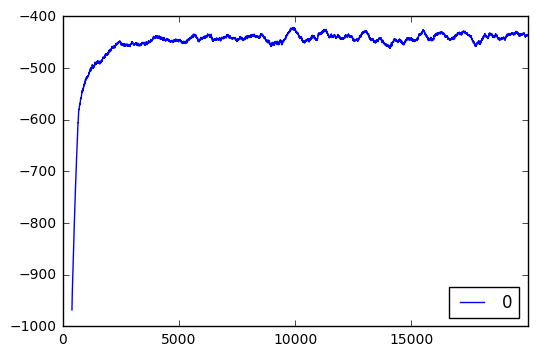

time: 353 ms


In [31]:
import pandas as pd
history_reward = exp.reward_history
d= pd.rolling_mean(pd.DataFrame(history_reward),400)
d.plot()
plt.show()

time: 4.01 ms


In [4]:
# Creates a graph.
with tf.device('/GPU:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)
    
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.
print(sess.run(c))

InvalidArgumentError: Cannot assign a device for operation 'MatMul_2': Operation was explicitly assigned to /device:GPU:0 but available devices are [ /job:localhost/replica:0/task:0/cpu:0 ]. Make sure the device specification refers to a valid device.
	 [[Node: MatMul_2 = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/device:GPU:0"](a_2, b_2)]]

Caused by op 'MatMul_2', defined at:
  File "C:\Program Files\Anaconda3\lib\runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Program Files\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\Program Files\Anaconda3\lib\site-packages\traitlets\config\application.py", line 653, in launch_instance
    app.start()
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "C:\Program Files\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "C:\Program Files\Anaconda3\lib\site-packages\tornado\ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "C:\Program Files\Anaconda3\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Program Files\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Program Files\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Program Files\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Program Files\Anaconda3\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-fa9d44ee79a4>", line 5, in <module>
    c = tf.matmul(a, b)
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\ops\math_ops.py", line 1816, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 1217, in _mat_mul
    transpose_b=transpose_b, name=name)
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Cannot assign a device for operation 'MatMul_2': Operation was explicitly assigned to /device:GPU:0 but available devices are [ /job:localhost/replica:0/task:0/cpu:0 ]. Make sure the device specification refers to a valid device.
	 [[Node: MatMul_2 = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/device:GPU:0"](a_2, b_2)]]


time: 907 ms


In [8]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

time: 3 ms


In [9]:
ee = get_available_gpus()

time: 997 µs


In [46]:
zeros1 = tf.zeros([3, 3])

time: 4 ms


In [47]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    

time: 4 ms
